## Programming Exercise 2 - Logistic Regression

In [134]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.special import expit

from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [135]:
def loaddata(file, delimeter):
    data = np.loadtxt(file, delimiter=delimeter)
    print('Dimensions: ',data.shape)
    print(data[1:6,:])
    return(data)

In [136]:
def plotData(data, label_x, label_y, label_pos, label_neg, axis=None):
    # Get indexes for class 0 and class 1
    neg = data[:,2] == 0
    pos = data[:,2] == 1
    
    if axis == None:
        axis = plt.gca()
    axis.scatter(data[pos][:,0], data[pos][:,1], marker='+', c='k', s=60, linewidth=2, label=label_pos)
    axis.scatter(data[neg][:,0], data[neg][:,1], c='y', s=60, label=label_neg)
    axis.set_xlabel(label_x)
    axis.set_ylabel(label_y)
    axis.legend(frameon= True, fancybox = True);

### Logistic Regression

In [137]:
data = loaddata('data/ex2data1.txt', ',')

Dimensions:  (100, 3)
[[ 30.28671077  43.89499752   0.        ]
 [ 35.84740877  72.90219803   0.        ]
 [ 60.18259939  86.3085521    1.        ]
 [ 79.03273605  75.34437644   1.        ]
 [ 45.08327748  56.31637178   0.        ]]


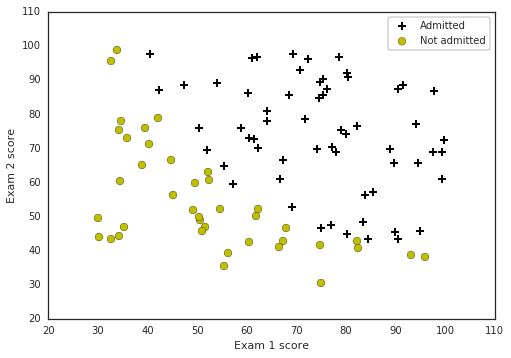

In [138]:
plotData(data, 'Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted')

#### Logistic regression hypothesis
### $$ h_{\theta}(x) = g(\theta^{T}x)$$
### $$ g(z)=\frac{1}{1+e^{−z}} $$

In [139]:
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

Scipy actually has a convenience function which does exactly the same:<BR>
http://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html#scipy.special.expit

#### Cost Function
### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big]$$
#### Vectorized Cost Function
### $$ J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big)$$

In [140]:
def costFunction(theta, *args):
    m = y.size
    h = sigmoid(X.dot(theta))
    J = -1*(1/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y))
    
    return(J)

#### Partial derivative

### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} $$ 
#### Vectorized
### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y)$$


In [141]:
def gradient(theta, *args):
    m = y.size
    h = sigmoid(X.dot(theta))
    grad =(1/m)*X.T.dot(h-y)

    return(grad)

In [142]:
X = np.c_[np.ones((data.shape[0],1)), data[:,0:2]]
y = np.c_[data[:,2]]

In [143]:
initial_theta = np.zeros((X.shape[1],1))
cost = costFunction(initial_theta, X, y)
grad = gradient(initial_theta, X, y)
print('Cost: \n', cost)
print('Grad: \n', grad)

Cost: 
 [[ 0.69314718]]
Grad: 
 [[ -0.1       ]
 [-12.00921659]
 [-11.26284221]]


#### Optimize cost function

In [144]:
res = minimize(costFunction, initial_theta, args=(X,y), method='TNC', jac=None, options={'maxiter':400})
res

     nit: 21
  status: 1
     jac: array([  1.36557432e-06,  -3.14889781e-04,   7.67494401e-04])
 success: True
       x: array([-25.1691087 ,   0.20627859,   0.20155135])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 104
     fun: array([ 0.20349772])

#### Predict

In [145]:
# Student with Exam 1 score 45 and Exam 2 score 85
# Predict using the optimized Theta values from above (res.x)
sigmoid(np.array([1, 45, 85]).dot(res.x.T))

0.77648384199166354

#### Decision boundary

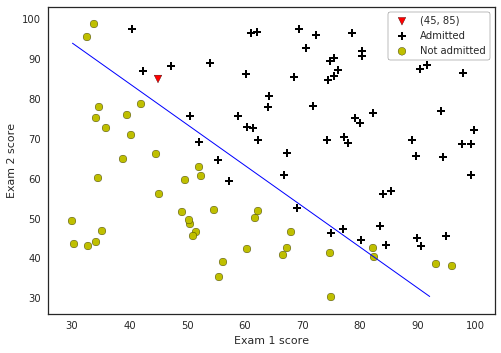

In [146]:
plt.scatter(45, 85, s=60, c='r', marker='v', label='(45, 85)')
plotData(data, 'Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted')
x1_min, x1_max = X[:,1].min(), X[:,1].max(),
x2_min, x2_max = X[:,2].min(), X[:,2].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
h = sigmoid(np.c_[np.ones((xx1.ravel().shape[0],1)), xx1.ravel(), xx2.ravel()].dot(res.x))
h = h.reshape(xx1.shape)
plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b');

### Regularized logistic regression

In [147]:
data2 = loaddata('data/ex2data2.txt', ',')

Dimensions:  (118, 3)
[[-0.092742  0.68494   1.      ]
 [-0.21371   0.69225   1.      ]
 [-0.375     0.50219   1.      ]
 [-0.51325   0.46564   1.      ]
 [-0.52477   0.2098    1.      ]]


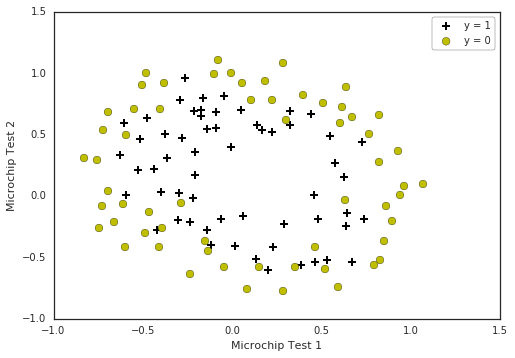

In [148]:
plotData(data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')

#### Polynomials

In [149]:
y = np.c_[data2[:,2]]
X = data2[:,0:2]

poly = PolynomialFeatures(6)
XX = poly.fit_transform(data2[:,0:2])
XX.shape

(118, 28)

#### Regularized Cost Function
### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$
#### Vectorized Cost Function
### $$ J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big) + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$

In [150]:
def costFunctionReg(theta, reg, *args):
    m = y.size
    h = sigmoid(XX.dot(theta))
    J = -1*(1/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y)) + (reg/(2*m))*np.sum(np.square(theta[1:]))
    return(J)

In [151]:
initial_theta = np.zeros((XX.shape[1],1))
costFunctionReg(initial_theta, 1, XX, y)

array([[ 0.69314718]])

In [152]:
def Regularization_level(reg, features, classes, axis):
    res2 = minimize(costFunctionReg, initial_theta, args=(reg, features, classes), method=None, jac=None, options={'maxiter':3000})
    plotData(data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0', axis)
    x1_min, x1_max = X[:,0].min(), X[:,0].max(),
    x2_min, x2_max = X[:,1].min(), X[:,1].max(),
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(res2.x))
    h = h.reshape(xx1.shape)
    axis.contour(xx1, xx2, h, [0.5], linewidths=1, colors='g');

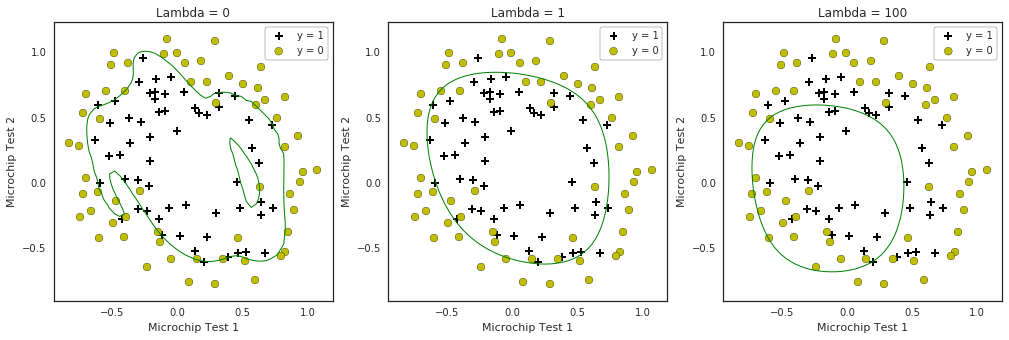

In [153]:
fig, axes = plt.subplots(1,3, figsize=(17,5))

for i, C in enumerate([0, 1, 100]):
    Regularization_level(C, XX, y, axes.flatten()[i])
    axes.flatten()[i].set_title('Lambda = '+str(C))